In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats
from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial
from scipy.stats import multivariate_normal
import random
import matplotlib

In [2]:
# AES sbox
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

In [86]:
# Hamming Weight: nr. of 1's in binary of given int value. e.g. HW[0] = 0, HW[255] = 8
HW = np.array([bin(n).count("1") for n in range(0, 256)])
HW

array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3,
       3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
       3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2,
       2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5,
       3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5,
       5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3,
       2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4,
       4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
       3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4,
       4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6,
       5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5,
       5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8])

In [3]:
def snr(obs_value, traces):
    max_val = np.max(obs_value)
    means = [None] * (max_val + 1)
    varss = [None] * (max_val + 1)
    for i in range(max_val + 1):
        means[i] = np.mean(traces[obs_value == i], axis=0)
        varss[i] = np.var(traces[obs_value == i], axis=0)
    means = np.array(means)
    varss = np.array(varss)
    snr = np.zeros_like(means[0])
    u_tot = np.mean(means, axis=0)
    v_tot = np.mean(varss, axis=0)
    for i in range(max_val + 1):
        snr += np.power(means[i]-u_tot, 2)
    snr = snr / v_tot
    return snr


# Correlation Power Analysis

In [ ]:
with h5py.File('AES_PTv2_Pinata.h5', "r") as in_file:
    pt = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    key = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])
    traces = np.array(in_file["Pinata/MS1/Attack/Traces"])

In [ ]:
attack_byte = 2

In [ ]:
plt.plot(snr(sbox[pt[:,attack_byte]^key[:,attack_byte]], traces))

In [ ]:
def partial_key(key_guess, attack_byte, pt, traces): # ^ = XOR
    # xoring plaintext with key guess
    hypotheses = np.array([HW[sbox[pt[i, attack_byte] ^ key_guess]] for i in range(pt.shape[0])])
    # we use the hypotheses and calculate the correlation
    
    return np.max(np.corrcoef(hypotheses, traces, rowvar=False)[0, 1:])

In [ ]:
# we have traces, lets take the HW leakage model, now we can do a correlation-based attack
# for this we don't need to use the training dataset, it is an unprofiled attack model

key_vector = np.zeros(256)
print(f"analysing {traces.shape[0]} traces")
print(f"attacking byte {attack_byte}")
for kguess in tqdm(range(256)):
    key_vector[kguess] = partial_key(key_guess=kguess, attack_byte=attack_byte, pt=pt, traces=traces)
    #if(kguess % 64 == 0):
    #    print(key_vector.shape)
print(f"key hypothesis with highest correlation: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

In [ ]:
plt.plot(key_vector)

In [ ]:
# with Pool() as pool:
#     key_vector = list(tqdm(pool.imap(partial(partial_key, attack_byte=attack_byte, pt=pt, traces=traces), range(256)), total=256))
# print(f"key hypothesis with highest correlation: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

# Differential Power Analysis

In [ ]:
# exercise: write the code to do a differential power analysis below

In [ ]:
# example of pointwise mean
a = np.array([[1,2,3]])
b = np.array([[7,8,9]])
np.mean([a,b], axis=0).flatten()

In [ ]:
key_vector = np.zeros(256)
print(f"analysing {traces.shape[0]} traces")
print(f"attacking byte {attack_byte}")

for kguess in tqdm(range(256)):
    #######
    ####### YOU ONLY NEED TO FILL IN THIS CODE INSIDE THE FOR-LOOP
    #######
    # make the hypotheses of the leaking value based on the key
    
    
    
    hypotheses = np.array([[sbox[pt[i, attack_byte] ^ kguess]] for i in range(pt.shape[0])]) #np.array([])
    #HW = bin(hypotheses)[-1]
    
    lsb_0=[]
    lsb_1=[]
    #print("shape of hypotheses", hypotheses.shape)
    # split the traces into 2 groups based on the LSB of the hypotheses, and calculate the point-wise mean of each
    for i, hyp in enumerate(hypotheses):
        hyp_out = bin(hyp[0])
        last_bit = hyp_out[-1]
        if(last_bit == '0'):
            lsb_0.append(traces[i])
        else:
            lsb_1.append(traces[i])
            
    lsb_0 = np.array(lsb_0)
    lsb_1 = np.array(lsb_1)
    #print("shape of lsb_0", lsb_0.shape)
    lsb_0= np.mean(lsb_0, axis=0)
    lsb_1= np.mean(lsb_1, axis=0)
    
    #print(traces)
        #print(hypotheses)
    
    
    # calculate the point-wise absolute difference between the 2 groups
    diff = np.abs(lsb_0 - lsb_1)
    # estimate the probability / likelihood of this keyguess as the maximum absolute point-wise difference between the groups
    key_vector[kguess] = np.max(diff)
    if(kguess == 0):
        plt.plot(diff)
        plt.show()

print(f"key hypothesis with highest DoM: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

# Template attack
Now we will run a template attack which is a type of profiled attack. It is quite simple in the sense that you build a multivariate normal distribution for each hamming weight. Then in the attacking stage you use these distributions to estimate the likelihood of your hypotheses.

In [ ]:
with h5py.File('AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/Unprotected/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/Unprotected/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/Unprotected/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/Unprotected/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/Unprotected/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/Unprotected/Attack/MetaData"]['key'])

In [ ]:
attack_byte=2

In [ ]:
# First we need to do PoI selection
snr_prof = snr(sbox[pt_prof[:,attack_byte]^key_prof[:,attack_byte]], traces_prof)
plt.plot(snr_prof)

# just take a window of 30 around the point of maximum leakage
window = (np.argmax(snr_prof)- 20, np.argmax(snr_prof) + 20)

In [ ]:
traces_hw = np.array([traces_prof[HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:,attack_byte]]] == hw, window[0]:window[1]] for hw in range(9)], dtype=object)
for hw in range(9):
    print(f"traces with hw {hw}: {traces_hw[hw].shape[0]}")

In [ ]:
mean_mat = np.array([np.mean(traces_hw[hw], axis=0) for hw in range(9)])
cov_mat = np.array([np.cov(traces_hw[hw], rowvar=False) for hw in range(9)])

In [ ]:
# we have built a multivariate normal distribution for each HW based on the profiling dataset, i.e. we have our model
# we can now run the attack on the attack dataset
key_vector = np.zeros(256)

# note: we only need to use 10 traces in our attack now
for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        distr = multivariate_normal(mean=mean_mat[hypothesis], cov=cov_mat[hypothesis])
        p_k = distr.pdf(traces_attack[i, window[0]:window[1]])
        key_vector[kguess] += np.log(p_k)
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

# Using ML for SCA
We will now look at a protected implementation. Specifically, the implementation is masked.

In [80]:
attack_byte = 0

In [81]:
with h5py.File('AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/MS1/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/MS1/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])
print(traces_prof.shape)
print(len(np.unique(traces_prof)))

(150000, 1500)
1375


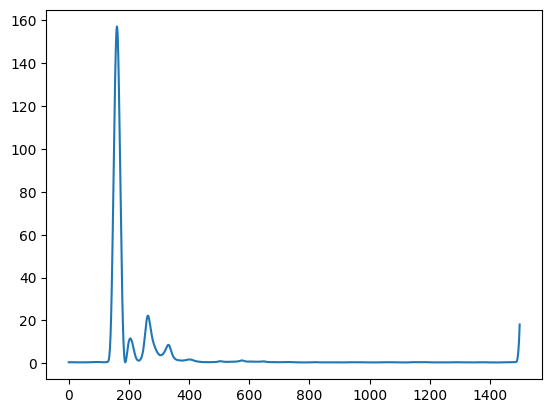

In [82]:
# the implementation is masked, but is it done correctly?
plt.plot(snr(sbox[pt_prof[:,attack_byte] ^ key_prof[:,attack_byte]], traces_prof))

In [83]:
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical
import tensorflow_addons as tfa

with tf.device("GPU"):
    start = layers.Input(shape=(1500, 1))

    # Convolution layer
    x = layers.Conv1D(8, 16, kernel_initializer='he_uniform',
                      activation='selu', padding='same')(start)
    x = layers.MaxPool1D(2, strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Flatten for dense layers
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(400, kernel_initializer='he_uniform',
                     activation='selu')(x)

    x = layers.Dense(50, kernel_initializer='he_uniform',
                    activation='selu')(x)
    
    # Classification layer
    end = layers.Dense(9, activation='softmax',
                       name='predictions')(x)

    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
        maximal_learning_rate=1e-2,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * traces_prof.shape[0]
    )

    model = tf.keras.models.Model(start, end)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(clr),
                  metrics=['accuracy'])

/Users/filippocasari/Dropbox/Mac/Downloads/AS3SecurityML/.conda/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/filippocasari/Dropbox/Mac/Downloads/AS3SecurityML/.conda/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:394: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: 

In [84]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [87]:
tf.debugging.set_log_device_placement(True)
with tf.device('GPU'):
    model.fit(x=traces_prof, y=to_categorical(HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]]),
                  batch_size=50, verbose=1,
                  epochs=40,
                  shuffle=True,
                  callbacks=[early_stopping],
                  validation_split=0.2,
             )

Epoch 1/40


2023-06-01 02:38:26.575716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 758/2400 [========>.....................] - ETA: 40s - loss: 1.6546 - accuracy: 0.3206

KeyboardInterrupt: 

In [ ]:
# predict probabilities and calculate log


In [ ]:
predictions = model.predict(traces_attack)
predictions = np.log(predictions + 1e-20)
key_vector = np.zeros(256)

for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        key_vector[kguess] += predictions[i, hypothesis]
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

In [213]:
def random_subset(size, *a):
    """
    Takes a random subset of size :size: from the given arrays. Makes sure that the rows of the arrays still match after shuffling.
    Example usage: subset_train, subset_labels = random_subset(10, training_set, training_labels)

    :size: size of the subset
    :*a: arrays to take subset of
    """
    combined = list(zip(*a))
    random.shuffle(combined)
    b = [np.array(i)[:size] for i in zip(*combined)]

    return b

def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    """
    Returns (guessing entropy, success rate) tuple of the given model over the given traces

    :traces: all available attacking traces
    :plaintext: all corresponding plaintext
    :key: the real key
    :byte: byte of key to attack
    :model: model used for making predictions
    :success_cutoff: cutoff to calculate success rate (key rank < success_cutoff)
    :nr_attack_traces: number of traces to use for attacking
    :averaging_nr: number of times to perform attack on subtraces in order to calculate the guessing entropy and success rate
    :track: boolean to indicate whether the guessing entropy should be tracked for each trace amount up to :nr_attack_traces:
    :data_augment: Default None. If not None, should be a function which takes traces as input and returns the augmented traces.
    """

    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(
            nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)
        
        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions+1e-20)
        _, leakage_mdl = predictions.shape
            
        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros(256)

        # for each trace, add up the log(probability) of each key hypothesis
        for i in tqdm(range(nr_attack_traces), desc='attack', leave=False):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                key_rank = list(np.argsort(key_probabilities)
                                [::-1]).index(key[byte])
                success = int(key_rank < success_cutoff)

                key_ranks[run, i] = key_rank
                successes[run, i] = success

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            # argsort()[::-1] -> sorts key values from most likely to least likely. Then get index of actual key byte to get the key rank.
            key_rank = list(np.argsort(key_probabilities)
                            [::-1]).index(key[byte])

            success = int(key_rank < success_cutoff)

            key_ranks[run] = key_rank
            successes[run] = success

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)

In [ ]:
ge, sr = ge_sr(traces_attack, pt_attack, key_attack[0], byte=attack_byte, model=model, success_cutoff=1,nr_attack_traces=10,averaging_nr=100, track=True)

In [ ]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()

In [ ]:
# exercise: rewrite the code (you can copy and paste it below if you want to preserve the original) to be in the ID leakage model

# ASCAD dataset

In [97]:
def read_data(file_loc, raw=False):
    """
    Reads in the ASCAD h5 dataset from the given dir_loc. If raw = False, reads ASCAD.h5 and assumes the simplified dataset structure.
    If raw = True, reads ATMega8515_raw_traces.h5 and assumes the raw traces dataset structure. 
    Returns the tuple: (x_train, x_test, plt_train, plt_test, keys_train, keys_test)
    :dir_loc: directory where the ASCAD dataset is located. Default = 'F:\\ASCAD\\ATMEGA_AES_v1\\ATM_AES_v1_fixed_key\\ASCAD_data\\ASCAD_databases\\'
    :data_name: Dataset name. Default = 'ASCAD.h5'
    """
    with h5py.File(file_loc, "r") as in_file:
        # Load traces
        x_train = np.array(
            in_file['Profiling_traces/traces'], dtype=np.int8)
        x_test = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
        # labels are sbox(plt[2] XOR key[2])
        
        labels_train = np.array(in_file['Profiling_traces/labels'])
        labels_test = np.array(in_file['Attack_traces/labels'])
        
        plt_train = np.array(
            in_file['Profiling_traces/metadata']['plaintext'])
        plt_test = np.array(in_file['Attack_traces/metadata']['plaintext'])

        keys_train = np.array(in_file['Profiling_traces/metadata']['key'])
        keys_test = np.array(in_file['Attack_traces/metadata']['key'])
        
        masks_train = np.array(in_file['Profiling_traces/metadata']['masks'])
        masks_test = np.array(in_file['Attack_traces/metadata']['masks'])
        
        return x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test

In [120]:
# load in data
# this dataset is synchronized, try to build a model to perform an attack!

x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test = read_data('Base_desync0.h5')


The 14 first elements of the mask array correspond to the masks r[3],··· ,r[16] in Algorithm 1 and the two last elements respectively correspond to r_in and r_out (the masks r [1] and r[2] have been forced to 0 for test/validation purpose)

You can find information about the dataset in the corresponding paper [here](https://link.springer.com/article/10.1007/s13389-019-00220-8)

In [227]:
# labels here are the output of the sbox of byte 2, i.e.
attack_byte = 2

np.all(sbox[plt_train[:,attack_byte] ^ keys_train[:,attack_byte]] == labels_train)

True

(50000, 700)
(50000, 16)
(50000, 16)


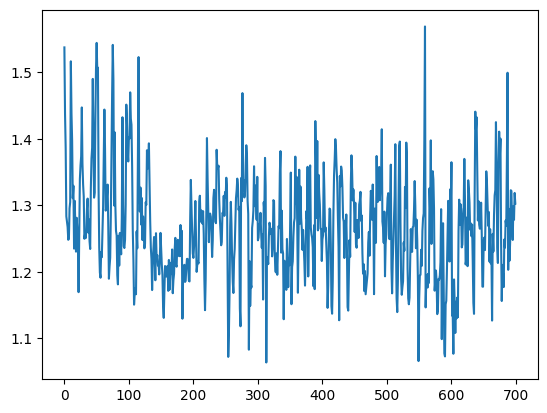

In [91]:
print(x_train.shape)
print(masks_train.shape)
print(plt_train.shape)
plt.plot(snr(sbox[plt_train[:,attack_byte] ^ keys_train[:,attack_byte]],x_train))

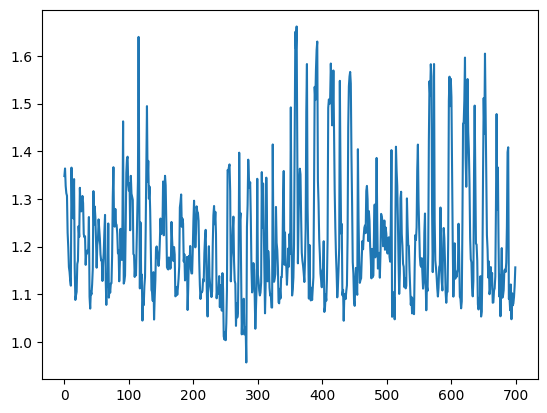

In [92]:
# it doesn't seem like the sbox output leaks..
# exercise: check if the masks leak
plt.plot(snr(sbox[plt_train[:,attack_byte]^ keys_train[:,attack_byte] ]^masks_train[:,attack_byte],x_train))


In [ ]:
# exercise: break the ASCAD dataset! You can use any kind of model, preprocessing, etc. you like, but keep the profiling - attack seperation

In [ ]:
# exercise: validate you can break the ASCAD dataset
# calculate the guessing entropy and the success rate when using the attack / test traces

In [ ]:
'''import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC(kernel='linear', C=1, gamma='auto', probability=True)
svc.fit(x_train, labels_train)
y_pred = svc.predict(x_test)
print(accuracy_score(labels_test, y_pred))'''

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
#from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import sys
class myCNN:
    
    def __init__(self, name="CNN"):
        self.name = name
        
    def cnn_best(self, classes=256,input_dim=700):
        # From VGG16 design
        input_shape = (input_dim,1)
        img_input = Input(shape=input_shape)
        # Block 1
        x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(img_input)
        x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
        # Block 2
        x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
        # Block 3
        x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
        # Block 4
        x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
        # Block 5
        x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    

        inputs = img_input
        # Create model.
        model = Model(inputs, x, name='cnn_best')
        optimizer = RMSprop(lr=1**(-5))
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    def mlp_best(self, node=200,layer_nb=6,input_dim=700):
        model = Sequential()
        model.add(Dense(node, input_dim=input_dim, activation='relu'))
        #model.add(Dropout(0.4))
        for i in range(layer_nb-2):
            model.add(Dense(node, activation='relu'))
        #model.add(Dropout(0.4))
        model.add(Dense(256, activation='softmax'))
        optimizer = RMSprop(lr=0.00001)
        #optimizer=Adam(lr=0.00001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    def cnn_best2(self, classes=256,input_dim=700):
        # From VGG16 design
        input_shape = (input_dim,1)
        img_input = Input(shape=input_shape)
        #x = layers.Normalization()(img_input)
        # Block 1
        x = Conv1D(64, 11, strides=2, activation='relu', padding='same', name='block1_conv1')(img_input)
        x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
        # Block 2
        x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
        x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
        # Block 3
        x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
        x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
        # Block 4
        x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
        x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
        # Block 5
        x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
        x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)

        inputs = img_input
        # Create model.
        model = Model(inputs, x, name='cnn_best2')
        optimizer = RMSprop(lr=0.00001, momentum=0.9)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    

def train_model(X_profiling, Y_profiling, model, save_file_name, epochs=150, batch_size=100, multilabel=0, validation_split=0, early_stopping=0):
    #check_file_exists(os.path.dirname(save_file_name))
    # Save model calllback
    save_model = ModelCheckpoint(save_file_name)
    callbacks=[save_model]
    # Early stopping callback
    if (early_stopping != 0):
        if validation_split == 0:
            validation_split=0.1
        callbacks.append(EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True))
    # Get the input layer shape
    if isinstance(model.get_layer(index=0).input_shape, list):
        input_layer_shape = model.get_layer(index=0).input_shape[0]
    else:
        input_layer_shape = model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        Reshaped_X_profiling = X_profiling
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
    #print(f"shape Reshaped X: {Reshaped_X_profiling.shape}")
    y=to_categorical(Y_profiling, num_classes=256)
    #y = tf.keras.utils.to_categorical(Y_profiling, num_classes=256)
    
    history = model.fit(x=Reshaped_X_profiling, y=y, batch_size=batch_size, verbose = 1, validation_split=validation_split, epochs=epochs, callbacks=callbacks)
    return history

In [181]:
#print(to_categorical(labels_train, num_classes=256))

#Model = myCNN().cnn_best()
# from paper https://eprint.iacr.org/2018/053.pdf. Using CNN and MPL. For CNN I used 100 epochs and 200 batch size. 
MPL = myCNN().cnn_best(input_dim=700)
MPL.summary()

Model: "cnn_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 block1_conv1 (Conv1D)       (None, 700, 64)           768       
                                                                 
 block1_pool (AveragePoolin  (None, 350, 64)           0         
 g1D)                                                            
                                                                 
 block2_conv1 (Conv1D)       (None, 350, 128)          90240     
                                                                 
 block2_pool (AveragePoolin  (None, 175, 128)          0         
 g1D)                                                            
                                                                 
 block3_conv1 (Conv1D)       (None, 175, 256)          360

In [182]:

tf.config.list_physical_devices('GPU')

print(labels_train.shape)
print(keys_train.shape)
print(keys_train)
with tf.device('GPU'):
    history =train_model(x_train, labels_train, MPL, "log", batch_size=200, epochs=75, validation_split=0.1)

(50000,)
(50000, 16)
[[ 77 251 224 ...  73   4 105]
 [ 77 251 224 ...  73   4 105]
 [ 77 251 224 ...  73   4 105]
 ...
 [ 77 251 224 ...  73   4 105]
 [ 77 251 224 ...  73   4 105]
 [ 77 251 224 ...  73   4 105]]
Epoch 1/100


2023-06-01 14:12:25.882606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - ETA: 0s - loss: 53.7270 - accuracy: 0.0037

2023-06-01 14:14:44.819445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 145s 642ms/step - loss: 53.7270 - accuracy: 0.0037 - val_loss: 5.5640 - val_accuracy: 0.0028
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 5.5486 - accuracy: 0.0043INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 561ms/step - loss: 5.5486 - accuracy: 0.0043 - val_loss: 5.5449 - val_accuracy: 0.0044
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 5.5439 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 564ms/step - loss: 5.5439 - accuracy: 0.0046 - val_loss: 5.5452 - val_accuracy: 0.0044
Epoch 4/100
225/225 [==============================] - ETA: 0s - loss: 5.5435 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 565ms/step - loss: 5.5435 - accuracy: 0.0046 - val_loss: 5.5454 - val_accuracy: 0.0044
Epoch 5/100
225/225 [==============================] - ETA: 0s - loss: 5.5433 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 564ms/step - loss: 5.5433 - accuracy: 0.0047 - val_loss: 5.5455 - val_accuracy: 0.0044
Epoch 6/100
225/225 [==============================] - ETA: 0s - loss: 5.5432 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5432 - accuracy: 0.0049 - val_loss: 5.5458 - val_accuracy: 0.0044
Epoch 7/100
225/225 [==============================] - ETA: 0s - loss: 5.5430 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 572ms/step - loss: 5.5430 - accuracy: 0.0046 - val_loss: 5.5462 - val_accuracy: 0.0044
Epoch 8/100
225/225 [==============================] - ETA: 0s - loss: 5.5430 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 130s 578ms/step - loss: 5.5430 - accuracy: 0.0048 - val_loss: 5.5461 - val_accuracy: 0.0044
Epoch 9/100
225/225 [==============================] - ETA: 0s - loss: 5.5429 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 249s 1s/step - loss: 5.5429 - accuracy: 0.0046 - val_loss: 5.5458 - val_accuracy: 0.0044
Epoch 10/100
225/225 [==============================] - ETA: 0s - loss: 5.5429 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 216s 963ms/step - loss: 5.5429 - accuracy: 0.0048 - val_loss: 5.5460 - val_accuracy: 0.0044
Epoch 11/100
225/225 [==============================] - ETA: 0s - loss: 5.5428 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5428 - accuracy: 0.0048 - val_loss: 5.5460 - val_accuracy: 0.0044
Epoch 12/100
225/225 [==============================] - ETA: 0s - loss: 5.5428 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5428 - accuracy: 0.0048 - val_loss: 5.5461 - val_accuracy: 0.0044
Epoch 13/100
225/225 [==============================] - ETA: 0s - loss: 5.5428 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 558ms/step - loss: 5.5428 - accuracy: 0.0049 - val_loss: 5.5461 - val_accuracy: 0.0044
Epoch 14/100
225/225 [==============================] - ETA: 0s - loss: 5.5428 - accuracy: 0.0043INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 125s 556ms/step - loss: 5.5428 - accuracy: 0.0043 - val_loss: 5.5462 - val_accuracy: 0.0044
Epoch 15/100
225/225 [==============================] - ETA: 0s - loss: 5.5427 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 125s 557ms/step - loss: 5.5427 - accuracy: 0.0049 - val_loss: 5.5462 - val_accuracy: 0.0044
Epoch 16/100
225/225 [==============================] - ETA: 0s - loss: 5.5427 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 567ms/step - loss: 5.5427 - accuracy: 0.0049 - val_loss: 5.5463 - val_accuracy: 0.0044
Epoch 17/100
225/225 [==============================] - ETA: 0s - loss: 5.5427 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 562ms/step - loss: 5.5427 - accuracy: 0.0048 - val_loss: 5.5463 - val_accuracy: 0.0044
Epoch 18/100
225/225 [==============================] - ETA: 0s - loss: 5.5427 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 566ms/step - loss: 5.5427 - accuracy: 0.0047 - val_loss: 5.5464 - val_accuracy: 0.0044
Epoch 19/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 124s 553ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5464 - val_accuracy: 0.0044
Epoch 20/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5464 - val_accuracy: 0.0044
Epoch 21/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 567ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5464 - val_accuracy: 0.0044
Epoch 22/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 564ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5465 - val_accuracy: 0.0044
Epoch 23/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 570ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5465 - val_accuracy: 0.0044
Epoch 24/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 561ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5465 - val_accuracy: 0.0044
Epoch 25/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 125s 554ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5466 - val_accuracy: 0.0044
Epoch 26/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 123s 549ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5466 - val_accuracy: 0.0044
Epoch 27/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 123s 547ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 28/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 124s 550ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 29/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 124s 549ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 30/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 31/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 32/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 124s 552ms/step - loss: 5.5426 - accuracy: 0.0047 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 33/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 562ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 34/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 35/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 561ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 36/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 332s 1s/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 37/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0046 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 38/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 561ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 39/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 561ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5467 - val_accuracy: 0.0044
Epoch 40/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 563ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 41/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0044INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 571ms/step - loss: 5.5426 - accuracy: 0.0044 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 42/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 133s 589ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 43/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 44/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 560ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 45/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 572ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 46/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 563ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 47/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0046 - val_loss: 5.5468 - val_accuracy: 0.0038
Epoch 48/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 49/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 565ms/step - loss: 5.5426 - accuracy: 0.0047 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 50/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 562ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 51/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 562ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 52/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 569ms/step - loss: 5.5426 - accuracy: 0.0047 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 53/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 574ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 54/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0044INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 130s 576ms/step - loss: 5.5426 - accuracy: 0.0044 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 55/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 574ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 56/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0045INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0045 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 57/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 125s 555ms/step - loss: 5.5426 - accuracy: 0.0047 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 58/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 125s 554ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 59/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 60/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 124s 553ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 61/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 126s 559ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 62/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 572ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 63/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 575ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 64/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 129s 573ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 65/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 130s 576ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 66/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 568ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 67/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0045INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 563ms/step - loss: 5.5426 - accuracy: 0.0045 - val_loss: 5.5468 - val_accuracy: 0.0044
Epoch 68/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 564ms/step - loss: 5.5426 - accuracy: 0.0046 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 69/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 565ms/step - loss: 5.5426 - accuracy: 0.0046 - val_loss: 5.5469 - val_accuracy: 0.0044
Epoch 70/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 565ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5470 - val_accuracy: 0.0044
Epoch 71/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0049INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 128s 568ms/step - loss: 5.5426 - accuracy: 0.0049 - val_loss: 5.5470 - val_accuracy: 0.0044
Epoch 72/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0047INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 563ms/step - loss: 5.5426 - accuracy: 0.0047 - val_loss: 5.5470 - val_accuracy: 0.0044
Epoch 73/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0046INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 562ms/step - loss: 5.5426 - accuracy: 0.0046 - val_loss: 5.5470 - val_accuracy: 0.0044
Epoch 74/100
225/225 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log/assets


INFO:tensorflow:Assets written to: log/assets


225/225 [==============================] - 127s 565ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5470 - val_accuracy: 0.0044
Epoch 75/100
 65/225 [=======>......................] - ETA: 1:28 - loss: 5.5435 - accuracy: 0.0048

KeyboardInterrupt: 

In [263]:
predictions = MPL.predict(x_test)
predictions = np.log(predictions + 1e-20)

313/313 [==============================] - 9s 28ms/step


In [241]:
#print(labels_test)
#print(keys_test.shape)


import itertools

key_vector = np.zeros(256)

for i, kguess in itertools.product((range(10)), range(256)):
    hypothesis = HW[sbox[plt_test[i, attack_byte] ^ kguess ]] #^masks_test[i, attack_byte]
    key_vector[kguess] += predictions[i, hypothesis]
print(np.argsort(key_vector))
index = np.where(np.argsort(key_vector)==keys_test[0][attack_byte])
print(f"position of the key {index[0][0]} over {len(key_vector)} positions")
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {keys_test[0][attack_byte]}")


[216  32 228  46 167 202  43 196  30 220  57  35 212 231 221   5  66  28
  47  21 207 211 164   2  84  95 215 113   8 210 169   1  39 159  29  60
  31 156 103 163   3 237 208  33 129  17  54 223  14 193  37 230  23 251
  34 233  42  94 198 254 214 244 119  79  77  69 144  53  20 239   6 150
 134 162 219  36 232 151 249 160 255 190  88  99 148 165 110  40 197 132
 147  62 247 206 226 168 172  81  85 155  96  61  25   4 199 201 253 114
  70 171 120 175  38 235 224  24  83 128  90  97 182  68 180 181 121 217
 246  50 227 152 189 125 101 222 192  10 124 122  80  49 139 118 245 126
 241  55 137 229  12 117 140 203 141  75 252 200  26 218 158 194   9  76
  91  63 191 108 127 240 146  78  16 174 248  71  45 154  44  27 173 166
  87 104 133 236  93 170  56 225 176 145 138 250 116   7 107  65  19  82
 106  86  89  67 130  15   0  51 123  41 183  13 213  18  74 185 161 186
  92  72 112 149 178 102 157 242 142  73 195 109 100 135  11 234 187 111
  22 243 177 179  59 153 238 209 143 115  58 136  5

run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

attack:   0%|          | 0/400 [00:00<?, ?it/s]

[]

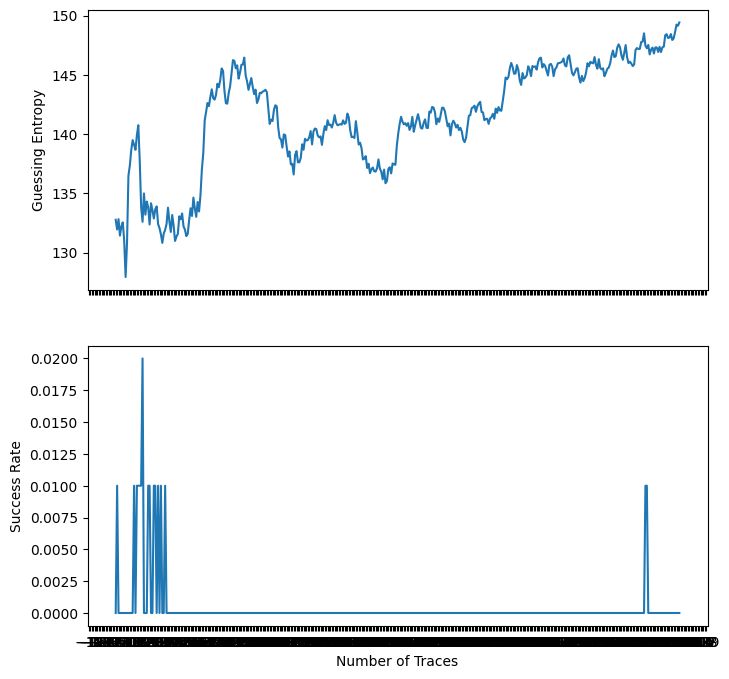

In [264]:

ge, sr=ge_sr(x_test, plt_test, keys_test[0], attack_byte, MPL,success_cutoff=1,nr_attack_traces=400,averaging_nr=100, track=True )
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()

In [247]:
from sklearn.decomposition import PCA
pca =PCA(n_components=100)
X_train = pca.fit_transform(x_train)
MPL2 = myCNN().mlp_best(input_dim=100)
tf.config.list_physical_devices('GPU')


with tf.device('GPU'):
    history =train_model(X_train, labels_train, MPL2, "log_mpl", batch_size=100, epochs=200, validation_split=0.1)


Epoch 1/200


2023-06-01 17:50:08.770419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - ETA: 0s - loss: 5.5543 - accuracy: 0.0040

2023-06-01 17:50:17.561787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 10s 20ms/step - loss: 5.5543 - accuracy: 0.0040 - val_loss: 5.5462 - val_accuracy: 0.0032
Epoch 2/200
450/450 [==============================] - ETA: 0s - loss: 5.5459 - accuracy: 0.0048INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 5.5459 - accuracy: 0.0048 - val_loss: 5.5487 - val_accuracy: 0.0054
Epoch 3/200
450/450 [==============================] - ETA: 0s - loss: 5.5426 - accuracy: 0.0048INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 5.5426 - accuracy: 0.0048 - val_loss: 5.5460 - val_accuracy: 0.0038
Epoch 4/200
448/450 [============================>.] - ETA: 0s - loss: 5.5244 - accuracy: 0.0060INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 5.5244 - accuracy: 0.0060 - val_loss: 5.5291 - val_accuracy: 0.0054
Epoch 5/200
449/450 [============================>.] - ETA: 0s - loss: 5.4839 - accuracy: 0.0069INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 5.4838 - accuracy: 0.0070 - val_loss: 5.5290 - val_accuracy: 0.0050
Epoch 6/200
450/450 [==============================] - ETA: 0s - loss: 5.4336 - accuracy: 0.0103INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 5.4336 - accuracy: 0.0103 - val_loss: 5.5027 - val_accuracy: 0.0064
Epoch 7/200
449/450 [============================>.] - ETA: 0s - loss: 5.3512 - accuracy: 0.0124INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.3513 - accuracy: 0.0125 - val_loss: 5.4721 - val_accuracy: 0.0102
Epoch 8/200
448/450 [============================>.] - ETA: 0s - loss: 5.2703 - accuracy: 0.0157INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.2710 - accuracy: 0.0156 - val_loss: 5.4543 - val_accuracy: 0.0082
Epoch 9/200
450/450 [==============================] - ETA: 0s - loss: 5.2019 - accuracy: 0.0197INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.2019 - accuracy: 0.0197 - val_loss: 5.4795 - val_accuracy: 0.0066
Epoch 10/200
450/450 [==============================] - ETA: 0s - loss: 5.1288 - accuracy: 0.0242INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.1288 - accuracy: 0.0242 - val_loss: 5.5412 - val_accuracy: 0.0088
Epoch 11/200
450/450 [==============================] - ETA: 0s - loss: 5.0531 - accuracy: 0.0287INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.0531 - accuracy: 0.0287 - val_loss: 5.6035 - val_accuracy: 0.0064
Epoch 12/200
450/450 [==============================] - ETA: 0s - loss: 4.9698 - accuracy: 0.0371INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.9698 - accuracy: 0.0371 - val_loss: 5.6551 - val_accuracy: 0.0048
Epoch 13/200
449/450 [============================>.] - ETA: 0s - loss: 4.8832 - accuracy: 0.0440INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8838 - accuracy: 0.0440 - val_loss: 5.7067 - val_accuracy: 0.0078
Epoch 14/200
450/450 [==============================] - ETA: 0s - loss: 4.7976 - accuracy: 0.0509INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7976 - accuracy: 0.0509 - val_loss: 5.7781 - val_accuracy: 0.0068
Epoch 15/200
450/450 [==============================] - ETA: 0s - loss: 4.6992 - accuracy: 0.0615INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6992 - accuracy: 0.0615 - val_loss: 5.9570 - val_accuracy: 0.0078
Epoch 16/200
448/450 [============================>.] - ETA: 0s - loss: 4.6068 - accuracy: 0.0720INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6064 - accuracy: 0.0719 - val_loss: 6.0813 - val_accuracy: 0.0068
Epoch 17/200
450/450 [==============================] - ETA: 0s - loss: 4.5181 - accuracy: 0.0796INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.5181 - accuracy: 0.0796 - val_loss: 6.1719 - val_accuracy: 0.0068
Epoch 18/200
450/450 [==============================] - ETA: 0s - loss: 4.4246 - accuracy: 0.0912INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.4246 - accuracy: 0.0912 - val_loss: 6.3363 - val_accuracy: 0.0078
Epoch 19/200
450/450 [==============================] - ETA: 0s - loss: 4.3313 - accuracy: 0.1014INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.3313 - accuracy: 0.1014 - val_loss: 6.5280 - val_accuracy: 0.0066
Epoch 20/200
448/450 [============================>.] - ETA: 0s - loss: 4.2413 - accuracy: 0.1136INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.2419 - accuracy: 0.1135 - val_loss: 6.5860 - val_accuracy: 0.0080
Epoch 21/200
448/450 [============================>.] - ETA: 0s - loss: 4.1528 - accuracy: 0.1256INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.1534 - accuracy: 0.1256 - val_loss: 6.7500 - val_accuracy: 0.0076
Epoch 22/200
449/450 [============================>.] - ETA: 0s - loss: 4.0731 - accuracy: 0.1350INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.0735 - accuracy: 0.1351 - val_loss: 7.0863 - val_accuracy: 0.0086
Epoch 23/200
450/450 [==============================] - ETA: 0s - loss: 3.9969 - accuracy: 0.1492INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.9969 - accuracy: 0.1492 - val_loss: 7.2081 - val_accuracy: 0.0090
Epoch 24/200
449/450 [============================>.] - ETA: 0s - loss: 3.9150 - accuracy: 0.1572INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.9153 - accuracy: 0.1572 - val_loss: 7.2713 - val_accuracy: 0.0082
Epoch 25/200
450/450 [==============================] - ETA: 0s - loss: 3.8455 - accuracy: 0.1689INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.8455 - accuracy: 0.1689 - val_loss: 7.3843 - val_accuracy: 0.0088
Epoch 26/200
450/450 [==============================] - ETA: 0s - loss: 3.7755 - accuracy: 0.1790INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.7755 - accuracy: 0.1790 - val_loss: 7.3547 - val_accuracy: 0.0066
Epoch 27/200
449/450 [============================>.] - ETA: 0s - loss: 3.7139 - accuracy: 0.1882INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.7137 - accuracy: 0.1883 - val_loss: 7.6494 - val_accuracy: 0.0076
Epoch 28/200
450/450 [==============================] - ETA: 0s - loss: 3.6508 - accuracy: 0.1977INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.6508 - accuracy: 0.1977 - val_loss: 7.9276 - val_accuracy: 0.0094
Epoch 29/200
448/450 [============================>.] - ETA: 0s - loss: 3.6019 - accuracy: 0.2103INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.6024 - accuracy: 0.2101 - val_loss: 8.1664 - val_accuracy: 0.0062
Epoch 30/200
450/450 [==============================] - ETA: 0s - loss: 3.5490 - accuracy: 0.2172INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.5490 - accuracy: 0.2172 - val_loss: 8.1007 - val_accuracy: 0.0080
Epoch 31/200
449/450 [============================>.] - ETA: 0s - loss: 3.5024 - accuracy: 0.2220INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.5023 - accuracy: 0.2220 - val_loss: 8.8774 - val_accuracy: 0.0066
Epoch 32/200
450/450 [==============================] - ETA: 0s - loss: 3.4560 - accuracy: 0.2303INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.4560 - accuracy: 0.2303 - val_loss: 8.5884 - val_accuracy: 0.0070
Epoch 33/200
450/450 [==============================] - ETA: 0s - loss: 3.4191 - accuracy: 0.2362INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.4191 - accuracy: 0.2362 - val_loss: 9.2064 - val_accuracy: 0.0076
Epoch 34/200
450/450 [==============================] - ETA: 0s - loss: 3.3759 - accuracy: 0.2462INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.3759 - accuracy: 0.2462 - val_loss: 9.2029 - val_accuracy: 0.0062
Epoch 35/200
450/450 [==============================] - ETA: 0s - loss: 3.3431 - accuracy: 0.2514INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.3431 - accuracy: 0.2514 - val_loss: 9.3063 - val_accuracy: 0.0078
Epoch 36/200
449/450 [============================>.] - ETA: 0s - loss: 3.3186 - accuracy: 0.2565INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.3184 - accuracy: 0.2564 - val_loss: 9.6862 - val_accuracy: 0.0082
Epoch 37/200
448/450 [============================>.] - ETA: 0s - loss: 3.2916 - accuracy: 0.2621INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.2928 - accuracy: 0.2620 - val_loss: 9.4239 - val_accuracy: 0.0076
Epoch 38/200
450/450 [==============================] - ETA: 0s - loss: 3.2675 - accuracy: 0.2670INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2675 - accuracy: 0.2670 - val_loss: 10.1088 - val_accuracy: 0.0074
Epoch 39/200
450/450 [==============================] - ETA: 0s - loss: 3.2420 - accuracy: 0.2701INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2420 - accuracy: 0.2701 - val_loss: 9.6351 - val_accuracy: 0.0076
Epoch 40/200
448/450 [============================>.] - ETA: 0s - loss: 3.2189 - accuracy: 0.2745INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2200 - accuracy: 0.2746 - val_loss: 10.9816 - val_accuracy: 0.0066
Epoch 41/200
449/450 [============================>.] - ETA: 0s - loss: 3.2156 - accuracy: 0.2786INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2155 - accuracy: 0.2786 - val_loss: 10.6652 - val_accuracy: 0.0080
Epoch 42/200
450/450 [==============================] - ETA: 0s - loss: 3.1970 - accuracy: 0.2795INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1970 - accuracy: 0.2795 - val_loss: 9.7814 - val_accuracy: 0.0074
Epoch 43/200
449/450 [============================>.] - ETA: 0s - loss: 3.1803 - accuracy: 0.2836INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1811 - accuracy: 0.2835 - val_loss: 10.4343 - val_accuracy: 0.0064
Epoch 44/200
449/450 [============================>.] - ETA: 0s - loss: 3.1709 - accuracy: 0.2880INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1705 - accuracy: 0.2881 - val_loss: 11.2452 - val_accuracy: 0.0086
Epoch 45/200
449/450 [============================>.] - ETA: 0s - loss: 3.1794 - accuracy: 0.2864INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1801 - accuracy: 0.2862 - val_loss: 11.2083 - val_accuracy: 0.0064
Epoch 46/200
450/450 [==============================] - ETA: 0s - loss: 3.1720 - accuracy: 0.2892INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1720 - accuracy: 0.2892 - val_loss: 10.5368 - val_accuracy: 0.0062
Epoch 47/200
450/450 [==============================] - ETA: 0s - loss: 3.1653 - accuracy: 0.2911INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 3.1653 - accuracy: 0.2911 - val_loss: 12.2365 - val_accuracy: 0.0064
Epoch 48/200
450/450 [==============================] - ETA: 0s - loss: 3.1698 - accuracy: 0.2913INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 3.1698 - accuracy: 0.2913 - val_loss: 10.2871 - val_accuracy: 0.0070
Epoch 49/200
449/450 [============================>.] - ETA: 0s - loss: 3.1884 - accuracy: 0.2878INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1887 - accuracy: 0.2878 - val_loss: 11.3119 - val_accuracy: 0.0062
Epoch 50/200
450/450 [==============================] - ETA: 0s - loss: 3.1998 - accuracy: 0.2917INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.1998 - accuracy: 0.2917 - val_loss: 11.5959 - val_accuracy: 0.0060
Epoch 51/200
450/450 [==============================] - ETA: 0s - loss: 3.2013 - accuracy: 0.2898INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2013 - accuracy: 0.2898 - val_loss: 11.3547 - val_accuracy: 0.0068
Epoch 52/200
448/450 [============================>.] - ETA: 0s - loss: 3.2215 - accuracy: 0.2872INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2235 - accuracy: 0.2868 - val_loss: 11.1538 - val_accuracy: 0.0056
Epoch 53/200
450/450 [==============================] - ETA: 0s - loss: 3.2248 - accuracy: 0.2915INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.2248 - accuracy: 0.2915 - val_loss: 11.3698 - val_accuracy: 0.0066
Epoch 54/200
449/450 [============================>.] - ETA: 0s - loss: 3.2398 - accuracy: 0.2882INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.2401 - accuracy: 0.2881 - val_loss: 12.4910 - val_accuracy: 0.0100
Epoch 55/200
448/450 [============================>.] - ETA: 0s - loss: 3.2495 - accuracy: 0.2879INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.2493 - accuracy: 0.2879 - val_loss: 12.1554 - val_accuracy: 0.0062
Epoch 56/200
449/450 [============================>.] - ETA: 0s - loss: 3.2743 - accuracy: 0.2858INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.2741 - accuracy: 0.2858 - val_loss: 13.3821 - val_accuracy: 0.0090
Epoch 57/200
448/450 [============================>.] - ETA: 0s - loss: 3.2870 - accuracy: 0.2831INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.2871 - accuracy: 0.2832 - val_loss: 11.7506 - val_accuracy: 0.0074
Epoch 58/200
450/450 [==============================] - ETA: 0s - loss: 3.3192 - accuracy: 0.2797INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.3192 - accuracy: 0.2797 - val_loss: 11.9323 - val_accuracy: 0.0086
Epoch 59/200
450/450 [==============================] - ETA: 0s - loss: 3.3378 - accuracy: 0.2771INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.3378 - accuracy: 0.2771 - val_loss: 12.2334 - val_accuracy: 0.0050
Epoch 60/200
449/450 [============================>.] - ETA: 0s - loss: 3.3726 - accuracy: 0.2763INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.3729 - accuracy: 0.2762 - val_loss: 12.6548 - val_accuracy: 0.0066
Epoch 61/200
450/450 [==============================] - ETA: 0s - loss: 3.4148 - accuracy: 0.2705INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.4148 - accuracy: 0.2705 - val_loss: 11.6845 - val_accuracy: 0.0064
Epoch 62/200
448/450 [============================>.] - ETA: 0s - loss: 3.4501 - accuracy: 0.2641INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.4512 - accuracy: 0.2640 - val_loss: 12.8424 - val_accuracy: 0.0072
Epoch 63/200
448/450 [============================>.] - ETA: 0s - loss: 3.4839 - accuracy: 0.2614INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.4863 - accuracy: 0.2612 - val_loss: 13.2435 - val_accuracy: 0.0058
Epoch 64/200
448/450 [============================>.] - ETA: 0s - loss: 3.5420 - accuracy: 0.2534INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.5414 - accuracy: 0.2536 - val_loss: 13.9536 - val_accuracy: 0.0062
Epoch 65/200
450/450 [==============================] - ETA: 0s - loss: 3.5820 - accuracy: 0.2492INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.5820 - accuracy: 0.2492 - val_loss: 11.6424 - val_accuracy: 0.0066
Epoch 66/200
449/450 [============================>.] - ETA: 0s - loss: 3.6515 - accuracy: 0.2408INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 3.6531 - accuracy: 0.2406 - val_loss: 11.9773 - val_accuracy: 0.0072
Epoch 67/200
450/450 [==============================] - ETA: 0s - loss: 3.6843 - accuracy: 0.2360INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 3.6843 - accuracy: 0.2360 - val_loss: 13.0528 - val_accuracy: 0.0064
Epoch 68/200
448/450 [============================>.] - ETA: 0s - loss: 3.7583 - accuracy: 0.2235INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 3.7590 - accuracy: 0.2234 - val_loss: 11.4159 - val_accuracy: 0.0054
Epoch 69/200
449/450 [============================>.] - ETA: 0s - loss: 3.8115 - accuracy: 0.2196INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 3.8120 - accuracy: 0.2195 - val_loss: 13.2019 - val_accuracy: 0.0072
Epoch 70/200
449/450 [============================>.] - ETA: 0s - loss: 3.8894 - accuracy: 0.2083INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.8897 - accuracy: 0.2081 - val_loss: 11.7221 - val_accuracy: 0.0056
Epoch 71/200
449/450 [============================>.] - ETA: 0s - loss: 3.9690 - accuracy: 0.1968INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 3.9693 - accuracy: 0.1967 - val_loss: 10.8302 - val_accuracy: 0.0068
Epoch 72/200
448/450 [============================>.] - ETA: 0s - loss: 4.0209 - accuracy: 0.1894INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.0204 - accuracy: 0.1892 - val_loss: 13.2342 - val_accuracy: 0.0076
Epoch 73/200
450/450 [==============================] - ETA: 0s - loss: 4.1382 - accuracy: 0.1778INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.1382 - accuracy: 0.1778 - val_loss: 10.3316 - val_accuracy: 0.0072
Epoch 74/200
449/450 [============================>.] - ETA: 0s - loss: 4.2635 - accuracy: 0.1620INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.2646 - accuracy: 0.1618 - val_loss: 9.4814 - val_accuracy: 0.0074
Epoch 75/200
450/450 [==============================] - ETA: 0s - loss: 4.3669 - accuracy: 0.1449INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.3669 - accuracy: 0.1449 - val_loss: 10.5645 - val_accuracy: 0.0068
Epoch 76/200
450/450 [==============================] - ETA: 0s - loss: 4.5071 - accuracy: 0.1260INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.5071 - accuracy: 0.1260 - val_loss: 9.6434 - val_accuracy: 0.0072
Epoch 77/200
449/450 [============================>.] - ETA: 0s - loss: 4.6526 - accuracy: 0.1079INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6535 - accuracy: 0.1077 - val_loss: 7.6352 - val_accuracy: 0.0050
Epoch 78/200
449/450 [============================>.] - ETA: 0s - loss: 4.7973 - accuracy: 0.0870INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7982 - accuracy: 0.0870 - val_loss: 7.7023 - val_accuracy: 0.0058
Epoch 79/200
450/450 [==============================] - ETA: 0s - loss: 4.9800 - accuracy: 0.0624INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.9800 - accuracy: 0.0624 - val_loss: 7.2232 - val_accuracy: 0.0046
Epoch 80/200
449/450 [============================>.] - ETA: 0s - loss: 5.1495 - accuracy: 0.0387INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.1494 - accuracy: 0.0387 - val_loss: 6.5863 - val_accuracy: 0.0044
Epoch 81/200
450/450 [==============================] - ETA: 0s - loss: 5.2081 - accuracy: 0.0276INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 5.2081 - accuracy: 0.0276 - val_loss: 5.8992 - val_accuracy: 0.0080
Epoch 82/200
448/450 [============================>.] - ETA: 0s - loss: 5.2495 - accuracy: 0.0201INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 5.2495 - accuracy: 0.0200 - val_loss: 5.7617 - val_accuracy: 0.0068
Epoch 83/200
449/450 [============================>.] - ETA: 0s - loss: 5.2374 - accuracy: 0.0174INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.2376 - accuracy: 0.0174 - val_loss: 5.7214 - val_accuracy: 0.0054
Epoch 84/200
450/450 [==============================] - ETA: 0s - loss: 5.1991 - accuracy: 0.0196INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.1991 - accuracy: 0.0196 - val_loss: 5.7118 - val_accuracy: 0.0052
Epoch 85/200
450/450 [==============================] - ETA: 0s - loss: 5.1641 - accuracy: 0.0208INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.1641 - accuracy: 0.0208 - val_loss: 5.7459 - val_accuracy: 0.0076
Epoch 86/200
449/450 [============================>.] - ETA: 0s - loss: 5.1254 - accuracy: 0.0223INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.1253 - accuracy: 0.0223 - val_loss: 5.8708 - val_accuracy: 0.0070
Epoch 87/200
450/450 [==============================] - ETA: 0s - loss: 5.0978 - accuracy: 0.0249INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.0978 - accuracy: 0.0249 - val_loss: 5.7918 - val_accuracy: 0.0096
Epoch 88/200
449/450 [============================>.] - ETA: 0s - loss: 5.0658 - accuracy: 0.0272INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 5.0658 - accuracy: 0.0272 - val_loss: 5.7044 - val_accuracy: 0.0070
Epoch 89/200
449/450 [============================>.] - ETA: 0s - loss: 5.0332 - accuracy: 0.0284INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.0336 - accuracy: 0.0284 - val_loss: 5.9729 - val_accuracy: 0.0052
Epoch 90/200
450/450 [==============================] - ETA: 0s - loss: 5.0019 - accuracy: 0.0312INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 5.0019 - accuracy: 0.0312 - val_loss: 5.9913 - val_accuracy: 0.0058
Epoch 91/200
449/450 [============================>.] - ETA: 0s - loss: 4.9800 - accuracy: 0.0326INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.9805 - accuracy: 0.0325 - val_loss: 5.8889 - val_accuracy: 0.0066
Epoch 92/200
448/450 [============================>.] - ETA: 0s - loss: 4.9582 - accuracy: 0.0350INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.9589 - accuracy: 0.0350 - val_loss: 5.9059 - val_accuracy: 0.0056
Epoch 93/200
449/450 [============================>.] - ETA: 0s - loss: 4.9251 - accuracy: 0.0371INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.9253 - accuracy: 0.0370 - val_loss: 6.3409 - val_accuracy: 0.0040
Epoch 94/200
448/450 [============================>.] - ETA: 0s - loss: 4.8983 - accuracy: 0.0391INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8983 - accuracy: 0.0392 - val_loss: 6.1176 - val_accuracy: 0.0076
Epoch 95/200
450/450 [==============================] - ETA: 0s - loss: 4.8824 - accuracy: 0.0392INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8824 - accuracy: 0.0392 - val_loss: 6.2103 - val_accuracy: 0.0074
Epoch 96/200
450/450 [==============================] - ETA: 0s - loss: 4.8621 - accuracy: 0.0418INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8621 - accuracy: 0.0418 - val_loss: 6.6682 - val_accuracy: 0.0074
Epoch 97/200
450/450 [==============================] - ETA: 0s - loss: 4.8517 - accuracy: 0.0410INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8517 - accuracy: 0.0410 - val_loss: 6.3830 - val_accuracy: 0.0074
Epoch 98/200
448/450 [============================>.] - ETA: 0s - loss: 4.8206 - accuracy: 0.0463INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8210 - accuracy: 0.0463 - val_loss: 6.4523 - val_accuracy: 0.0064
Epoch 99/200
449/450 [============================>.] - ETA: 0s - loss: 4.8105 - accuracy: 0.0456INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8103 - accuracy: 0.0456 - val_loss: 6.4609 - val_accuracy: 0.0058
Epoch 100/200
450/450 [==============================] - ETA: 0s - loss: 4.7912 - accuracy: 0.0459INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7912 - accuracy: 0.0459 - val_loss: 6.4404 - val_accuracy: 0.0062
Epoch 101/200
448/450 [============================>.] - ETA: 0s - loss: 4.7816 - accuracy: 0.0471INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7813 - accuracy: 0.0471 - val_loss: 6.7201 - val_accuracy: 0.0056
Epoch 102/200
449/450 [============================>.] - ETA: 0s - loss: 4.7624 - accuracy: 0.0482INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7627 - accuracy: 0.0482 - val_loss: 6.7687 - val_accuracy: 0.0072
Epoch 103/200
450/450 [==============================] - ETA: 0s - loss: 4.7465 - accuracy: 0.0488INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7465 - accuracy: 0.0488 - val_loss: 6.6481 - val_accuracy: 0.0086
Epoch 104/200
450/450 [==============================] - ETA: 0s - loss: 4.7438 - accuracy: 0.0514INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7438 - accuracy: 0.0514 - val_loss: 6.8736 - val_accuracy: 0.0052
Epoch 105/200
449/450 [============================>.] - ETA: 0s - loss: 4.7232 - accuracy: 0.0529INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7235 - accuracy: 0.0529 - val_loss: 6.9764 - val_accuracy: 0.0054
Epoch 106/200
448/450 [============================>.] - ETA: 0s - loss: 4.7103 - accuracy: 0.0538INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7103 - accuracy: 0.0538 - val_loss: 6.8981 - val_accuracy: 0.0058
Epoch 107/200
448/450 [============================>.] - ETA: 0s - loss: 4.6999 - accuracy: 0.0530INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.6999 - accuracy: 0.0530 - val_loss: 7.0293 - val_accuracy: 0.0068
Epoch 108/200
449/450 [============================>.] - ETA: 0s - loss: 4.6973 - accuracy: 0.0551INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.6973 - accuracy: 0.0552 - val_loss: 7.0526 - val_accuracy: 0.0066
Epoch 109/200
450/450 [==============================] - ETA: 0s - loss: 4.6910 - accuracy: 0.0565INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6910 - accuracy: 0.0565 - val_loss: 7.1312 - val_accuracy: 0.0050
Epoch 110/200
450/450 [==============================] - ETA: 0s - loss: 4.6721 - accuracy: 0.0554INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6721 - accuracy: 0.0554 - val_loss: 7.7227 - val_accuracy: 0.0062
Epoch 111/200
450/450 [==============================] - ETA: 0s - loss: 4.6631 - accuracy: 0.0580INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6631 - accuracy: 0.0580 - val_loss: 7.2446 - val_accuracy: 0.0034
Epoch 112/200
448/450 [============================>.] - ETA: 0s - loss: 4.6646 - accuracy: 0.0580INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6638 - accuracy: 0.0580 - val_loss: 7.9637 - val_accuracy: 0.0078
Epoch 113/200
448/450 [============================>.] - ETA: 0s - loss: 4.6560 - accuracy: 0.0572INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6566 - accuracy: 0.0572 - val_loss: 7.0747 - val_accuracy: 0.0066
Epoch 114/200
450/450 [==============================] - ETA: 0s - loss: 4.6558 - accuracy: 0.0562INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6558 - accuracy: 0.0562 - val_loss: 7.5505 - val_accuracy: 0.0066
Epoch 115/200
450/450 [==============================] - ETA: 0s - loss: 4.6550 - accuracy: 0.0572INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6550 - accuracy: 0.0572 - val_loss: 7.4779 - val_accuracy: 0.0064
Epoch 116/200
450/450 [==============================] - ETA: 0s - loss: 4.6491 - accuracy: 0.0587INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6491 - accuracy: 0.0587 - val_loss: 7.4730 - val_accuracy: 0.0086
Epoch 117/200
449/450 [============================>.] - ETA: 0s - loss: 4.6540 - accuracy: 0.0571INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6537 - accuracy: 0.0570 - val_loss: 8.4740 - val_accuracy: 0.0060
Epoch 118/200
449/450 [============================>.] - ETA: 0s - loss: 4.6438 - accuracy: 0.0586INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6430 - accuracy: 0.0586 - val_loss: 8.5421 - val_accuracy: 0.0056
Epoch 119/200
450/450 [==============================] - ETA: 0s - loss: 4.6476 - accuracy: 0.0585INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6476 - accuracy: 0.0585 - val_loss: 8.0513 - val_accuracy: 0.0066
Epoch 120/200
449/450 [============================>.] - ETA: 0s - loss: 4.6558 - accuracy: 0.0584INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6563 - accuracy: 0.0583 - val_loss: 7.6642 - val_accuracy: 0.0064
Epoch 121/200
450/450 [==============================] - ETA: 0s - loss: 4.6461 - accuracy: 0.0577INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6461 - accuracy: 0.0577 - val_loss: 7.9265 - val_accuracy: 0.0072
Epoch 122/200
450/450 [==============================] - ETA: 0s - loss: 4.6444 - accuracy: 0.0579INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6444 - accuracy: 0.0579 - val_loss: 7.5203 - val_accuracy: 0.0084
Epoch 123/200
450/450 [==============================] - ETA: 0s - loss: 4.6451 - accuracy: 0.0595INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6451 - accuracy: 0.0595 - val_loss: 7.0635 - val_accuracy: 0.0050
Epoch 124/200
449/450 [============================>.] - ETA: 0s - loss: 4.6414 - accuracy: 0.0588INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.6417 - accuracy: 0.0588 - val_loss: 7.9693 - val_accuracy: 0.0060
Epoch 125/200
449/450 [============================>.] - ETA: 0s - loss: 4.6554 - accuracy: 0.0591INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6552 - accuracy: 0.0591 - val_loss: 7.9701 - val_accuracy: 0.0076
Epoch 126/200
450/450 [==============================] - ETA: 0s - loss: 4.6399 - accuracy: 0.0598INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6399 - accuracy: 0.0598 - val_loss: 8.2822 - val_accuracy: 0.0070
Epoch 127/200
448/450 [============================>.] - ETA: 0s - loss: 4.6499 - accuracy: 0.0591INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6509 - accuracy: 0.0592 - val_loss: 8.0673 - val_accuracy: 0.0062
Epoch 128/200
450/450 [==============================] - ETA: 0s - loss: 4.6568 - accuracy: 0.0571INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.6568 - accuracy: 0.0571 - val_loss: 8.4192 - val_accuracy: 0.0070
Epoch 129/200
448/450 [============================>.] - ETA: 0s - loss: 4.6652 - accuracy: 0.0582INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.6652 - accuracy: 0.0582 - val_loss: 7.7111 - val_accuracy: 0.0060
Epoch 130/200
448/450 [============================>.] - ETA: 0s - loss: 4.6765 - accuracy: 0.0579INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6768 - accuracy: 0.0580 - val_loss: 8.0666 - val_accuracy: 0.0050
Epoch 131/200
449/450 [============================>.] - ETA: 0s - loss: 4.6722 - accuracy: 0.0555INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6729 - accuracy: 0.0554 - val_loss: 7.5083 - val_accuracy: 0.0072
Epoch 132/200
449/450 [============================>.] - ETA: 0s - loss: 4.6984 - accuracy: 0.0553INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6988 - accuracy: 0.0553 - val_loss: 8.0585 - val_accuracy: 0.0054
Epoch 133/200
449/450 [============================>.] - ETA: 0s - loss: 4.7012 - accuracy: 0.0541INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7012 - accuracy: 0.0541 - val_loss: 7.9686 - val_accuracy: 0.0078
Epoch 134/200
449/450 [============================>.] - ETA: 0s - loss: 4.6986 - accuracy: 0.0527INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.6992 - accuracy: 0.0527 - val_loss: 8.0519 - val_accuracy: 0.0082
Epoch 135/200
449/450 [============================>.] - ETA: 0s - loss: 4.7254 - accuracy: 0.0518INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7252 - accuracy: 0.0518 - val_loss: 7.5616 - val_accuracy: 0.0054
Epoch 136/200
450/450 [==============================] - ETA: 0s - loss: 4.7160 - accuracy: 0.0511INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7160 - accuracy: 0.0511 - val_loss: 7.8449 - val_accuracy: 0.0062
Epoch 137/200
450/450 [==============================] - ETA: 0s - loss: 4.7047 - accuracy: 0.0514INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7047 - accuracy: 0.0514 - val_loss: 8.3978 - val_accuracy: 0.0048
Epoch 138/200
450/450 [==============================] - ETA: 0s - loss: 4.7158 - accuracy: 0.0509INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7158 - accuracy: 0.0509 - val_loss: 8.2038 - val_accuracy: 0.0076
Epoch 139/200
449/450 [============================>.] - ETA: 0s - loss: 4.7398 - accuracy: 0.0506INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7394 - accuracy: 0.0506 - val_loss: 8.3282 - val_accuracy: 0.0056
Epoch 140/200
450/450 [==============================] - ETA: 0s - loss: 4.7430 - accuracy: 0.0500INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7430 - accuracy: 0.0500 - val_loss: 7.9489 - val_accuracy: 0.0058
Epoch 141/200
450/450 [==============================] - ETA: 0s - loss: 4.7167 - accuracy: 0.0510INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7167 - accuracy: 0.0510 - val_loss: 8.6483 - val_accuracy: 0.0056
Epoch 142/200
448/450 [============================>.] - ETA: 0s - loss: 4.7395 - accuracy: 0.0498INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7385 - accuracy: 0.0498 - val_loss: 8.9147 - val_accuracy: 0.0062
Epoch 143/200
448/450 [============================>.] - ETA: 0s - loss: 4.7479 - accuracy: 0.0491INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.7475 - accuracy: 0.0491 - val_loss: 7.4956 - val_accuracy: 0.0050
Epoch 144/200
449/450 [============================>.] - ETA: 0s - loss: 4.7507 - accuracy: 0.0477INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7510 - accuracy: 0.0476 - val_loss: 8.2706 - val_accuracy: 0.0068
Epoch 145/200
450/450 [==============================] - ETA: 0s - loss: 4.7587 - accuracy: 0.0461INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7587 - accuracy: 0.0461 - val_loss: 8.1077 - val_accuracy: 0.0056
Epoch 146/200
449/450 [============================>.] - ETA: 0s - loss: 4.7575 - accuracy: 0.0471INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7579 - accuracy: 0.0471 - val_loss: 7.9423 - val_accuracy: 0.0068
Epoch 147/200
448/450 [============================>.] - ETA: 0s - loss: 4.7678 - accuracy: 0.0457INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7675 - accuracy: 0.0458 - val_loss: 7.8421 - val_accuracy: 0.0068
Epoch 148/200
450/450 [==============================] - ETA: 0s - loss: 4.7653 - accuracy: 0.0459INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.7653 - accuracy: 0.0459 - val_loss: 7.7160 - val_accuracy: 0.0078
Epoch 149/200
448/450 [============================>.] - ETA: 0s - loss: 4.7832 - accuracy: 0.0435INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.7832 - accuracy: 0.0434 - val_loss: 8.4359 - val_accuracy: 0.0064
Epoch 150/200
449/450 [============================>.] - ETA: 0s - loss: 4.7871 - accuracy: 0.0432INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7872 - accuracy: 0.0432 - val_loss: 7.8687 - val_accuracy: 0.0068
Epoch 151/200
450/450 [==============================] - ETA: 0s - loss: 4.7749 - accuracy: 0.0446INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7749 - accuracy: 0.0446 - val_loss: 8.7083 - val_accuracy: 0.0070
Epoch 152/200
449/450 [============================>.] - ETA: 0s - loss: 5.0114 - accuracy: 0.0438INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 5.0108 - accuracy: 0.0438 - val_loss: 8.2792 - val_accuracy: 0.0068
Epoch 153/200
449/450 [============================>.] - ETA: 0s - loss: 4.7736 - accuracy: 0.0429INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7734 - accuracy: 0.0429 - val_loss: 8.0081 - val_accuracy: 0.0082
Epoch 154/200
448/450 [============================>.] - ETA: 0s - loss: 4.7881 - accuracy: 0.0400INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7889 - accuracy: 0.0399 - val_loss: 8.3531 - val_accuracy: 0.0058
Epoch 155/200
449/450 [============================>.] - ETA: 0s - loss: 4.7883 - accuracy: 0.0415INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7884 - accuracy: 0.0415 - val_loss: 7.9388 - val_accuracy: 0.0056
Epoch 156/200
449/450 [============================>.] - ETA: 0s - loss: 4.7967 - accuracy: 0.0413INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7969 - accuracy: 0.0413 - val_loss: 7.6392 - val_accuracy: 0.0066
Epoch 157/200
449/450 [============================>.] - ETA: 0s - loss: 4.8198 - accuracy: 0.0402INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8199 - accuracy: 0.0402 - val_loss: 7.7792 - val_accuracy: 0.0086
Epoch 158/200
449/450 [============================>.] - ETA: 0s - loss: 4.8104 - accuracy: 0.0397INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8108 - accuracy: 0.0396 - val_loss: 7.1760 - val_accuracy: 0.0058
Epoch 159/200
449/450 [============================>.] - ETA: 0s - loss: 4.8091 - accuracy: 0.0376INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.8095 - accuracy: 0.0376 - val_loss: 8.3144 - val_accuracy: 0.0054
Epoch 160/200
450/450 [==============================] - ETA: 0s - loss: 4.8255 - accuracy: 0.0384INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8255 - accuracy: 0.0384 - val_loss: 8.9966 - val_accuracy: 0.0084
Epoch 161/200
450/450 [==============================] - ETA: 0s - loss: 4.8271 - accuracy: 0.0384INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8271 - accuracy: 0.0384 - val_loss: 7.6613 - val_accuracy: 0.0058
Epoch 162/200
449/450 [============================>.] - ETA: 0s - loss: 4.7997 - accuracy: 0.0394INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7994 - accuracy: 0.0394 - val_loss: 8.4931 - val_accuracy: 0.0082
Epoch 163/200
449/450 [============================>.] - ETA: 0s - loss: 4.8097 - accuracy: 0.0377INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8095 - accuracy: 0.0378 - val_loss: 8.2994 - val_accuracy: 0.0088
Epoch 164/200
449/450 [============================>.] - ETA: 0s - loss: 4.8021 - accuracy: 0.0373INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8022 - accuracy: 0.0374 - val_loss: 9.0676 - val_accuracy: 0.0076
Epoch 165/200
448/450 [============================>.] - ETA: 0s - loss: 4.7943 - accuracy: 0.0375INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7943 - accuracy: 0.0374 - val_loss: 7.5754 - val_accuracy: 0.0066
Epoch 166/200
450/450 [==============================] - ETA: 0s - loss: 4.8084 - accuracy: 0.0372INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8084 - accuracy: 0.0372 - val_loss: 7.6904 - val_accuracy: 0.0064
Epoch 167/200
448/450 [============================>.] - ETA: 0s - loss: 4.7983 - accuracy: 0.0370INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7986 - accuracy: 0.0370 - val_loss: 8.1633 - val_accuracy: 0.0076
Epoch 168/200
448/450 [============================>.] - ETA: 0s - loss: 4.7933 - accuracy: 0.0373INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7939 - accuracy: 0.0373 - val_loss: 7.7387 - val_accuracy: 0.0072
Epoch 169/200
449/450 [============================>.] - ETA: 0s - loss: 4.7901 - accuracy: 0.0375INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.7907 - accuracy: 0.0375 - val_loss: 7.7231 - val_accuracy: 0.0050
Epoch 170/200
448/450 [============================>.] - ETA: 0s - loss: 4.8149 - accuracy: 0.0365INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8176 - accuracy: 0.0365 - val_loss: 6.9625 - val_accuracy: 0.0068
Epoch 171/200
448/450 [============================>.] - ETA: 0s - loss: 4.8100 - accuracy: 0.0359INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8100 - accuracy: 0.0359 - val_loss: 8.0131 - val_accuracy: 0.0048
Epoch 172/200
450/450 [==============================] - ETA: 0s - loss: 4.8056 - accuracy: 0.0349INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8056 - accuracy: 0.0349 - val_loss: 7.9642 - val_accuracy: 0.0064
Epoch 173/200
448/450 [============================>.] - ETA: 0s - loss: 4.8191 - accuracy: 0.0350INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.8194 - accuracy: 0.0350 - val_loss: 7.9268 - val_accuracy: 0.0062
Epoch 174/200
448/450 [============================>.] - ETA: 0s - loss: 4.7977 - accuracy: 0.0347INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7986 - accuracy: 0.0346 - val_loss: 7.9160 - val_accuracy: 0.0086
Epoch 175/200
449/450 [============================>.] - ETA: 0s - loss: 4.8014 - accuracy: 0.0341INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8013 - accuracy: 0.0341 - val_loss: 8.5872 - val_accuracy: 0.0066
Epoch 176/200
449/450 [============================>.] - ETA: 0s - loss: 4.7890 - accuracy: 0.0343INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7888 - accuracy: 0.0344 - val_loss: 7.8675 - val_accuracy: 0.0054
Epoch 177/200
448/450 [============================>.] - ETA: 0s - loss: 4.7874 - accuracy: 0.0324INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7869 - accuracy: 0.0324 - val_loss: 7.8158 - val_accuracy: 0.0070
Epoch 178/200
448/450 [============================>.] - ETA: 0s - loss: 4.8016 - accuracy: 0.0329INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8019 - accuracy: 0.0329 - val_loss: 8.3655 - val_accuracy: 0.0076
Epoch 179/200
448/450 [============================>.] - ETA: 0s - loss: 4.7981 - accuracy: 0.0337INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7980 - accuracy: 0.0337 - val_loss: 7.2531 - val_accuracy: 0.0064
Epoch 180/200
450/450 [==============================] - ETA: 0s - loss: 4.7950 - accuracy: 0.0339INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7950 - accuracy: 0.0339 - val_loss: 8.2570 - val_accuracy: 0.0056
Epoch 181/200
450/450 [==============================] - ETA: 0s - loss: 4.7955 - accuracy: 0.0330INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 8s 19ms/step - loss: 4.7955 - accuracy: 0.0330 - val_loss: 7.3931 - val_accuracy: 0.0064
Epoch 182/200
449/450 [============================>.] - ETA: 0s - loss: 4.8006 - accuracy: 0.0332INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8000 - accuracy: 0.0333 - val_loss: 8.2238 - val_accuracy: 0.0064
Epoch 183/200
450/450 [==============================] - ETA: 0s - loss: 4.7995 - accuracy: 0.0329INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7995 - accuracy: 0.0329 - val_loss: 7.6008 - val_accuracy: 0.0056
Epoch 184/200
450/450 [==============================] - ETA: 0s - loss: 4.8084 - accuracy: 0.0328INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8084 - accuracy: 0.0328 - val_loss: 8.1459 - val_accuracy: 0.0066
Epoch 185/200
448/450 [============================>.] - ETA: 0s - loss: 4.8076 - accuracy: 0.0322INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.8077 - accuracy: 0.0322 - val_loss: 8.2052 - val_accuracy: 0.0072
Epoch 186/200
448/450 [============================>.] - ETA: 0s - loss: 4.7957 - accuracy: 0.0335INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7955 - accuracy: 0.0335 - val_loss: 8.3142 - val_accuracy: 0.0050
Epoch 187/200
449/450 [============================>.] - ETA: 0s - loss: 4.7764 - accuracy: 0.0331INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7759 - accuracy: 0.0331 - val_loss: 8.1071 - val_accuracy: 0.0068
Epoch 188/200
450/450 [==============================] - ETA: 0s - loss: 4.7773 - accuracy: 0.0327INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.7773 - accuracy: 0.0327 - val_loss: 7.7933 - val_accuracy: 0.0052
Epoch 189/200
449/450 [============================>.] - ETA: 0s - loss: 4.7928 - accuracy: 0.0330INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 20ms/step - loss: 4.7930 - accuracy: 0.0329 - val_loss: 7.9207 - val_accuracy: 0.0068
Epoch 190/200
449/450 [============================>.] - ETA: 0s - loss: 4.7973 - accuracy: 0.0324INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7978 - accuracy: 0.0324 - val_loss: 7.6848 - val_accuracy: 0.0046
Epoch 191/200
450/450 [==============================] - ETA: 0s - loss: 4.7711 - accuracy: 0.0327INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7711 - accuracy: 0.0327 - val_loss: 8.7659 - val_accuracy: 0.0066
Epoch 192/200
450/450 [==============================] - ETA: 0s - loss: 4.7934 - accuracy: 0.0307INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7934 - accuracy: 0.0307 - val_loss: 7.6661 - val_accuracy: 0.0060
Epoch 193/200
448/450 [============================>.] - ETA: 0s - loss: 4.7715 - accuracy: 0.0318INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7714 - accuracy: 0.0318 - val_loss: 7.9735 - val_accuracy: 0.0080
Epoch 194/200
449/450 [============================>.] - ETA: 0s - loss: 4.7796 - accuracy: 0.0326INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7797 - accuracy: 0.0326 - val_loss: 7.6646 - val_accuracy: 0.0062
Epoch 195/200
448/450 [============================>.] - ETA: 0s - loss: 4.7709 - accuracy: 0.0310INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7722 - accuracy: 0.0310 - val_loss: 8.2230 - val_accuracy: 0.0054
Epoch 196/200
448/450 [============================>.] - ETA: 0s - loss: 4.7884 - accuracy: 0.0309INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7886 - accuracy: 0.0310 - val_loss: 8.6020 - val_accuracy: 0.0074
Epoch 197/200
450/450 [==============================] - ETA: 0s - loss: 4.7758 - accuracy: 0.0312INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7758 - accuracy: 0.0312 - val_loss: 8.1993 - val_accuracy: 0.0076
Epoch 198/200
450/450 [==============================] - ETA: 0s - loss: 4.7718 - accuracy: 0.0312INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7718 - accuracy: 0.0312 - val_loss: 9.1390 - val_accuracy: 0.0058
Epoch 199/200
450/450 [==============================] - ETA: 0s - loss: 4.7782 - accuracy: 0.0317INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7782 - accuracy: 0.0317 - val_loss: 8.8529 - val_accuracy: 0.0064
Epoch 200/200
450/450 [==============================] - ETA: 0s - loss: 4.7675 - accuracy: 0.0317INFO:tensorflow:Assets written to: log_mpl/assets


INFO:tensorflow:Assets written to: log_mpl/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7675 - accuracy: 0.0317 - val_loss: 7.9728 - val_accuracy: 0.0068


In [249]:
X_test = pca.transform(x_test)
predictions = MPL2.predict(X_test)
predictions = np.log(predictions + 1e-20)

 22/313 [=>............................] - ETA: 1s

2023-06-01 18:22:13.048522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


In [258]:

import itertools

key_vector = np.zeros(256)

for i, kguess in itertools.product((range(10)), range(256)):
    hypothesis = HW[sbox[plt_test[i, attack_byte] ^ kguess ]] #^masks_test[i, attack_byte]
    key_vector[kguess] += predictions[i, hypothesis]
print(np.argsort(key_vector))
index = np.where(np.argsort(key_vector)==keys_test[0][attack_byte])
print(f"position of the key {index[0][0]} over {len(key_vector)} positions")
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {keys_test[0][attack_byte]}")

[164 230  32  20 216  39 170 121 168   2 223  28 138 246  46  21  30 139
  76 219   8  35  33 236  43 220  40  26  10  22  56 118 147   6 171   3
  14 213 208 120  60  94  47  27 126  85 116 169  16 172  48 111 176 218
   9 194 128  74 166  11  55 212  38 182   4  63 135  68 196  51  70 101
  41  79 149  54 127 125 207 114 232 152 160 247 133 252 154  90 132 141
 162  77 167 231 237 159  84 222  86 202 110 221  71 251 211 210 146 156
 109 117 165  57 129 197  93  81  91 191  19  24 228  34 163 201 238 119
 254  62 131  78 206  96  50   5 190 148 185   0 240 243 103 255 130 150
 215  29 239 217 145 134 107 241  92  31 180 155 124 143 181 248 151  13
 113  82  64  45 161   7 234 203  99 157  59 195 177 144 140  66  61  15
   1 204 158  58  72 112  75 226 137  18  83 199 224 183  67  44 153 136
  87 229 187 214  53  42 123 253 104  37 200 122 250  95  65 249  80 174
  12 115 108 225  36  97 198 244 233  89  88  23 186  73  52 205 209 242
 178 102 100 188 105 193  69  17 235 189  49 245 17

run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

attack:   0%|          | 0/600 [00:00<?, ?it/s]

[]

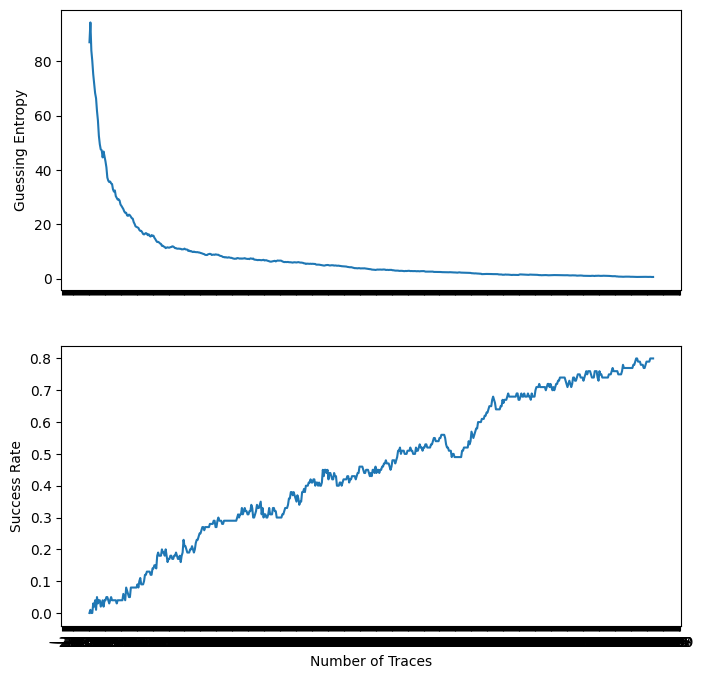

In [261]:
ge, sr=ge_sr(X_test, plt_test, keys_test[0], attack_byte, MPL2,success_cutoff=1,nr_attack_traces=600,averaging_nr=100, track=True)
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()